# Task 1: Setting the Baseline 
## Task 1.1 Data Preparation and Validation Pipeline

In [134]:
import pandas as pd 
import numpy as np

df_raw_train = pd.read_csv("./kaggle/input/3bodyproblem/mlNOVA/mlNOVA/X_train.csv")
df_raw_test = pd.read_csv("./kaggle/input/3bodyproblem/mlNOVA/mlNOVA/X_test.csv")

### Check for any missing values

In [135]:
print("Summary of the missing\nvalues in the training set\n")
print(df_raw_train.isna().sum())
print()

print("Summary of the missing\nvalues in the test set\n")
print(df_raw_test.isna().sum())

Summary of the missing
values in the training set

t        0
x_1      0
y_1      0
v_x_1    0
v_y_1    0
x_2      0
y_2      0
v_x_2    0
v_y_2    0
x_3      0
y_3      0
v_x_3    0
v_y_3    0
Id       0
dtype: int64

Summary of the missing
values in the test set

Id      0
t       0
x0_1    0
y0_1    0
x0_2    0
y0_2    0
x0_3    0
y0_3    0
dtype: int64


### Visualize few trajectories

In [ ]:
import matplotlib.pyplot as plt

start = 0
end = 257

for i in range(5):
    trajectory = df_raw_train[start:end]
    x1, y1, x2, y2, x3, y3 = trajectory.x_1, trajectory.y_1, trajectory.x_2, trajectory.y_2, trajectory.x_3, trajectory.y_3
    plt.plot(x1, y1, color="hotpink", label = "Body 1")
    plt.plot(x2, y2, color="blue", label = "Body 2")
    plt.plot(x3, y3, color="purple", label = "Body 3")
    plt.scatter(x1[start], y1[start], color="hotpink")
    plt.scatter(x2[start], y2[start], color="blue")
    plt.scatter(x3[start], y3[start], color="purple")
    plt.xlabel("X")
    plt.ylabel("Y", rotation=0)
    plt.title("Trajectory no." + str(i+1))
    plt.legend()
    plt.tight_layout()
    plt.show()

    start += 257
    end += 257


### Prepare the dataset

In [100]:
df_raw_train["group"] = df_raw_train["Id"]//257

In [101]:
#All starting positions
df_init = df_raw_train[ df_raw_train.index%257 == 0]

In [102]:
df_combined = df_raw_train.merge(df_init, on="group",  suffixes=('', '_init'))

# Step 1: Create a list/array of unique group_ids
unique_groups = df_combined['Id_init'].unique()

# Step 2: Create a random mask for this list
mask_train_test = np.random.rand(len(unique_groups)) < 0.8  # random True/False values

# Step 3: Split unique groups into two sets
group_train = unique_groups[mask_train_test]  # groups for the training set
group_testing = unique_groups[~mask_train_test]  # groups for the test set

# Step 4: Use the mask to split the DataFrame
train_set = df_combined[df_combined['Id_init'].isin(group_train)]
testing_set = df_combined[df_combined['Id_init'].isin(group_testing)]


unique_groups_train_validation = testing_set['Id_init'].unique()

mask_val_test = np.random.rand(len(unique_groups_train_validation)) < 0.5

group_validation = unique_groups_train_validation[mask_val_test]  # groups for the training set
group_test = unique_groups_train_validation[~mask_val_test]  # groups for the test set

validation_set = testing_set[testing_set['Id_init'].isin(group_validation)]
test_set = testing_set[testing_set['Id_init'].isin(group_test)]



### Remove following zeros after bodies collision (optional)

In [103]:
# train_set = train_set.drop_duplicates(subset=[col for col in train_set.columns if col != 'id'])
# train_set.head()

#### Display sets

In [ ]:
train_set

In [ ]:
validation_set

In [ ]:
test_set

### Verify dataset splitting

In [ ]:
# Get sorted unique Id_init values
unique_sorted_ids_train = sorted(set(train_set['Id_init'].values))
unique_sorted_ids_val = sorted(set(validation_set['Id_init'].values))
unique_sorted_ids_test = sorted(set(test_set['Id_init'].values))

# Find intersection of the two sets
intersection_ids1 = sorted(set(unique_sorted_ids_train) & set(unique_sorted_ids_val))
intersection_ids2 = sorted(set(unique_sorted_ids_train) & set(unique_sorted_ids_test))
intersection_ids3 = sorted(set(unique_sorted_ids_test) & set(unique_sorted_ids_val))

# Display the results]
print("Intersection of IDs:", intersection_ids1)
print("Intersection of IDs:", intersection_ids2)
print("Intersection of IDs:", intersection_ids3)

### Prepare input and output sets

In [ ]:
input_train = train_set[["t","x_1_init", "y_1_init", "x_2_init", "y_2_init", "x_3_init", "y_3_init"]]
input_validation = validation_set[["t","x_1_init", "y_1_init", "x_2_init", "y_2_init", "x_3_init", "y_3_init"]]
input_test = test_set[["t","x_1_init", "y_1_init", "x_2_init", "y_2_init", "x_3_init", "y_3_init"]]
input_submission = df_raw_test.drop(columns=["Id"]).rename(columns={"t": "t", "x0_1": "x_1_init", "y0_1": "y_1_init", "x0_2": "x_2_init", "y0_2": "y_2_init", "x0_3": "x_3_init", "y0_3": "y_3_init"})
input_submission.head()

In [ ]:
input_validation.head()

In [ ]:
output_train = train_set[["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]]
output_validation = validation_set[["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]]
output_test = test_set[["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]]

output_train.head()

In [ ]:
output_validation.head()

In [ ]:
groups = train_set["group"]
groups

#### Function to save predictions to csv


In [113]:
def save_predictions_to_csv(predictions: np.ndarray, output_file_name: str):

    """
    Saves the given NumPy array with predictions to a CSV file.

    Parameters:
    - predictions (np.ndarray): A NumPy array containing the data to be saved.
    - output_file_name (str): The name of the output CSV file (without .csv extension).
    """

    predictions_df = pd.DataFrame(predictions, columns=["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"])
    predictions_df.insert(0, 'Id', range(len(predictions_df)))
    predictions_df.to_csv("./output/csv/"+output_file_name+".csv", index=False)

### Drop columns (optional)

In [130]:
# columns=["y_3_init","x_3_init"]
# test_set=test_set.drop(columns=columns)
# input_test=input_test.drop(columns=columns)
# input_validation=input_validation.drop(columns=columns)
# input_train=input_train.drop(columns=columns)
# input_submission=input_submission.drop(columns=columns)

In [ ]:
input_validation.head()

## Task 1.2 Learn the baseline model

In [116]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

nn = MLPRegressor(random_state=1, max_iter=3)
svm = SVR(kernel="linear")
model = LinearRegression()
modelRidge = Ridge()
modelLasso = Lasso()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe = Pipeline(
    [
            ('scaling', StandardScaler()), 
            ("model", model)
    ])
pipe

In [ ]:
from sklearn.metrics import root_mean_squared_error
    
pipe.fit(input_train, output_train)
y_hat = pipe.predict(input_validation)
y_hat_test = pipe.predict(input_test)
y_hat_submission = pipe.predict(input_submission)
save_predictions_to_csv(y_hat_test, "baseline_test")
save_predictions_to_csv(y_hat_submission, "baseline-model")
rmse = root_mean_squared_error(output_validation, y_hat)
rmse_test = root_mean_squared_error(output_test, y_hat_test)

print("RMSE: ", rmse)
print("RMSE Test: ", rmse_test)

In [120]:
import numpy as np

def plot_y_yhat(y_validation, y_pred, plot_title = "plot"):
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    MAX = 500
    if len(y_validation) > MAX:
        idx = np.random.choice(len(y_validation),MAX, replace=False)
    else:
        idx = np.arange(len(y_validation))
    plt.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_validation[idx,i])
        x1 = np.max(y_validation[idx,i])
        plt.subplot(3,2,i+1)
        plt.scatter(y_validation[idx,i],y_pred[idx,i])
        plt.xlabel('True '+labels[i])
        plt.ylabel('Predicted '+labels[i])
        plt.plot([x0,x1],[x0,x1],color='red')
        plt.axis('square')
    plt.suptitle(plot_title)
    plt.savefig("./output/plots/"+plot_title+'.pdf')
    plt.show()

In [ ]:
plot_y_yhat(output_validation.to_numpy(), pd.DataFrame(y_hat).to_numpy(), plot_title="baseline")

# Task 2: Nonlinear models on the data — the Polynomial Regression model

## Task 2.1 Development

In [122]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeCV
from sklearn.metrics import root_mean_squared_error

def validate_poly_regression(X_train, y_train, X_val, y_val, regressor=None, degrees=range(1,9), max_features=None):
    #best_rsme = [1000, 1000, 1000]
    best_degrees_rsmes = [[0, 1000], [0, 1000], [0, 1000]]
    train_scores = []
    validation_scores = []
    n_features_list = []

    for d in degrees:
        print("Degree ", d)

        pipe_d_degree= Pipeline(
    [       ('preprocessor', PolynomialFeatures(degree=d)),
            ('model', RidgeCV(alphas=np.logspace(-6, 6, 13)))
    ])

        pipe_d_degree.fit(X_train, y_train)

        n_features = pipe_d_degree.named_steps['preprocessor'].n_output_features_
        n_features_list.append(n_features)

        y_train_predict = pipe_d_degree.predict(X_train)
        y_val_predict = pipe_d_degree.predict(X_val)


        train_error = root_mean_squared_error(y_train, y_train_predict)
        #print("Train RMSE:", train_error)

        val_error = root_mean_squared_error(y_val, y_val_predict)
        print("Val RMSE:", val_error)

        if val_error < best_degrees_rsmes[2][1]:
            best_degrees_rsmes[2][1] = val_error
            best_degrees_rsmes[2][0] = d
            best_degrees_rsmes.sort(key=lambda x: x[1], reverse=False)

        train_scores.append(train_error)
        validation_scores.append(val_error)
    
    best_degrees = [item[0] for item in best_degrees_rsmes]
    best_rsmes = [item[1] for item in best_degrees_rsmes]

    return train_scores, validation_scores, best_rsmes, best_degrees, n_features_list

In [ ]:
degrees=range(1,9)
degree_scores = {d: {'train_scores': [], 'test_scores': []} for d in degrees}
best_rsmes = []
best_degrees = []

for _ in range(10):

    sample_train_set = train_set.sample(frac=0.01)
    sample_input_train = sample_train_set[["t","x_1_init", "y_1_init", "x_2_init", "y_2_init", "x_3_init", "y_3_init"]]
    sample_output_train = sample_train_set[["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]]
    
    train_scores, validation_scores, best_rsme, best_degree, n_features_list = validate_poly_regression(sample_input_train, sample_output_train, input_validation, output_validation, degrees=degrees)

    best_rsmes.append(min(best_rsme))
    best_degrees.append(best_degree[0])
    best_degrees.append(best_degree[1])
    best_degrees.append(best_degree[2])

    for d in degrees:
        degree_scores[d]['train_scores'].append(train_scores[d-1])
        degree_scores[d]['test_scores'].append(validation_scores[d-1])

print(n_features_list)

In [ ]:
import matplotlib.pyplot as plt

# Create bin edges so that each bar is centered on its respective integer
bin_edges = [i - 0.5 for i in range(1, len(degrees) + 2)]  # Create bin edges

plt.hist(best_degrees, bins=bin_edges, color='pink', edgecolor='black')

plt.xticks(range(1, len(degrees) + 1))
plt.yaxis.get_major_locator().set_params(integer=True)

plt.title('Distribution of Selected Polynomial Degrees')
plt.xlabel('Degree')
plt.ylabel('Number of times in TOP3 degrees')

plt.show()

In [ ]:
plt.plot(best_rsmes, color='hotpink')
plt.title('RMSE throughout 10 runs')
plt.xlabel('# of run')
plt.ylabel('RMSE')
plt.show()

### Train with the best-degree model


In [ ]:
#best_degree_ever = max(set(best_degrees), key=best_degrees.count)
best_degree_ever=3
print("Best degree", best_degree_ever)

pipe_best_degree= Pipeline(
[       ('preprocessor', PolynomialFeatures(degree=best_degree_ever)),
        ('model', RidgeCV(alphas=np.logspace(-6, 6, 13)))
])

pipe_best_degree.fit(input_train, output_train)

output_train_predict = pipe_best_degree.predict(input_train)
output_val_predict = pipe_best_degree.predict(input_validation)
output_test_predict = pipe_best_degree.predict(input_test)
output_submission_predict = pipe_best_degree.predict(input_submission)

save_predictions_to_csv(output_test_predict, "poly_test")
save_predictions_to_csv(output_submission_predict, "polynomial_submission")

train_error = root_mean_squared_error(output_train, output_train_predict)
print("Train RMSE:", train_error)

val_error = root_mean_squared_error(output_validation, output_val_predict)
print("Validation RMSE:", val_error)

### Train with the 3 best-degree models on more data


In [ ]:
from collections import Counter

top_3_degrees = Counter(best_degrees).most_common(3)

most_frequent_degrees = [degree for degree, count in top_3_degrees]

print("Top 3 most frequent degrees:", sorted(most_frequent_degrees))

In [ ]:
degrees=sorted(most_frequent_degrees)
degree_scores = {d: {'train_scores': [], 'test_scores': []} for d in degrees}
best_rsmes_after_selection = []
best_degrees_after_selection = []

for _ in range(5):

    sample_train_set = train_set.sample(frac=0.35)
    sample_input_train = sample_train_set[["t","x_1_init", "y_1_init", "x_2_init", "y_2_init", "x_3_init", "y_3_init"]]
    sample_output_train = sample_train_set[["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]]
    
    train_scores, validation_scores, best_rsme, best_degree, n_features_list = validate_poly_regression(sample_input_train, sample_output_train, input_validation, output_validation, degrees=degrees)

    best_index = best_rsme.index(min(best_rsme))
    best_rsmes_after_selection.append(best_rsme[best_index])
    best_degrees_after_selection.append(best_degree[best_index])

    for d in degrees:
        degree_scores[d]['train_scores'].append(train_scores[d-1])
        degree_scores[d]['test_scores'].append(validation_scores[d-1])

In [ ]:
# Create bin edges so that each bar is centered on its respective integer
bin_edges = [i - 0.5 for i in range(1, len(degrees) + 2)]  # Create bin edges

plt.hist(best_degrees_after_selection, bins=bin_edges, color='pink', edgecolor='black')

plt.xticks(range(1, len(most_frequent_degrees) + 1))
plt.yaxis.get_major_locator().set_params(integer=True)

plt.title('Distribution of Selected Polynomial Degrees')
plt.xlabel('Degree')
plt.ylabel('Frequency')

plt.show()

### Train on the best-degree model on all data


In [ ]:
best_degree_ever = max(set(best_degrees), key=best_degrees.count)

print("Best degree", best_degree_ever)

pipe_best_degree= Pipeline(
[       ('preprocessor', PolynomialFeatures(degree=best_degree_ever)),
        ('model', RidgeCV(alphas=np.logspace(-6, 6, 13)))
])

pipe_best_degree.fit(input_train, output_train)

output_train_predict = pipe_best_degree.predict(input_train)
output_val_predict = pipe_best_degree.predict(input_validation)

train_error = root_mean_squared_error(output_train, output_train_predict)
print("Train RMSE:", train_error)

val_error = root_mean_squared_error(output_validation, output_val_predict)
print("Validation RMSE:", val_error)

## Task 2.2 Evaluation

In [ ]:
plot_y_yhat(output_validation.to_numpy(), pd.DataFrame(output_val_predict).to_numpy(), plot_title="polynomial")

# Task 3: Feature Engineering
## Task 3.1 Removing variables

### Seaborn plot

In [ ]:
import seaborn as sns
df_train=train_set[["t","x_1", "v_x_1", "y_1","v_y_1", "x_2", "v_x_2", "y_2", "v_y_2", "x_3", "v_x_3", "y_3", "v_y_3"]]
sns.pairplot(df_train.sample(200), kind="hist")

### Check linear corelations

In [ ]:
corr = df_train.corr()
sns.heatmap(corr,annot=True)

In [ ]:
# Correlation map with absolute values

sns.heatmap(corr.abs(),annot=True)

### Tests for dropping columns and pair of columns

In [136]:
import itertools
# List to store results
results = []
rmse_base=rmse
# Columns to consider for dropping
columns = input_train.columns

# Iterate over combinations of 1, 2, and 3 columns
for num_columns in range(1, 4):
    for combo in itertools.combinations(columns, num_columns):
        modified_input = input_train.drop(columns=list(combo))
        pipe.fit(modified_input, output_train)
        y_hat = pipe.predict(input_validation.drop(columns=list(combo)))
        rmse = root_mean_squared_error(output_validation, y_hat)
        results.append((combo, rmse*10000))

# Sort results by RMSE
sorted_results = sorted(results, key=lambda x: x[1])

# Print sorted results
for combo, rmse in sorted_results:
    print(f"Columns dropped: {combo}")
    print(f"RMSE: {(rmse-(rmse_base*10000))}")
    print("-" * 30)

Columns dropped: ('x_1_init', 'y_1_init')
RMSE: -130905973.46560475
------------------------------
Columns dropped: ('x_1_init',)
RMSE: -130905973.46560475
------------------------------
Columns dropped: ('y_1_init',)
RMSE: -130905973.20551574
------------------------------
Columns dropped: ('x_1_init', 'y_2_init')
RMSE: -130905867.79830514
------------------------------
Columns dropped: ('x_1_init', 'y_1_init', 'y_2_init')
RMSE: -130905867.79830514
------------------------------
Columns dropped: ('y_2_init',)
RMSE: -130905867.780008
------------------------------
Columns dropped: ('y_1_init', 'y_2_init')
RMSE: -130905867.780008
------------------------------
Columns dropped: ('x_1_init', 'x_2_init')
RMSE: -130905702.11254106
------------------------------
Columns dropped: ('x_1_init', 'y_1_init', 'x_2_init')
RMSE: -130905702.11254106
------------------------------
Columns dropped: ('y_1_init', 'x_2_init')
RMSE: -130905701.98295414
------------------------------
Columns dropped: ('x_2_

In [137]:
from sklearn.metrics import root_mean_squared_error, mean_squared_error
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import math

# Removing different variables

model = LinearRegression()
pipe1 = Pipeline(
    [
            ('scaling', StandardScaler()), 
            ("model", model)
    ])

reduced_input=input_train[["t","x_1_init","y_1_init","x_2_init", "y_2_init","x_3_init", "y_3_init"]]
reduced_val=input_validation[["t","x_1_init","y_1_init","x_2_init", "y_2_init","x_3_init", "y_3_init"]]

# Function to calculate RMSE
def calculate_rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred, squared=False)
    return math.sqrt(mse)

# Initialize baseline RMSE
pipe1.fit(reduced_input, output_train)
y_hat1 = pipe1.predict(reduced_val)
baseline_rmse = calculate_rmse(output_validation, y_hat1)

print("Baseline RMSE: ", baseline_rmse)

f_to_remove=["t","x_1_init","y_1_init","x_2_init", "y_2_init","x_3_init", "y_3_init"]

# Loop to remove one variable at a time
for i in range(len(f_to_remove)):
    # Create a new list of features excluding the i-th feature
    reduced_features = f_to_remove[:i] + f_to_remove[i+1:]
    
    # Refit the model using reduced features
    pipe1.fit(input_train[reduced_features], output_train)
    y_hat_reduced = pipe1.predict(input_validation[reduced_features])
    
    # Calculate RMSE for the reduced model
    rmse_reduced = calculate_rmse(output_validation, y_hat_reduced)
    
    print(f"RMSE after removing {f_to_remove[i]}: {rmse_reduced}")

KeyError: "['x_3_init', 'y_3_init'] not in index"

In [ ]:
from sklearn.metrics import root_mean_squared_error, mean_squared_error
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import math

# Remove y3 and x3

model = LinearRegression()
pipe1 = Pipeline(
    [
            ('scaling', StandardScaler()), 
            ("model", model)
    ])

reduced_input=input_train[["t","x_1_init","y_1_init","x_2_init", "y_2_init"]]
reduced_val=input_validation[["t","x_1_init","y_1_init","x_2_init", "y_2_init"]]

# Function to calculate RMSE
def calculate_rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred, squared=False)
    return math.sqrt(mse)

# Initialize baseline RMSE
pipe1.fit(reduced_input, output_train)
y_hat1 = pipe1.predict(reduced_val)
baseline_rmse = calculate_rmse(output_validation, y_hat1)

print("After removing y3 and x3: ", baseline_rmse)

In [ ]:
plot_y_yhat(output_validation.to_numpy(), pd.DataFrame(y_hat1).to_numpy())


In [ ]:
# MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

pipe3 = Pipeline(
    [('scaling', MinMaxScaler()), 
    ("model", LinearRegression())

    ]
)
pipe3.fit(input_train[["t","x_1_init","y_1_init","x_2_init", "y_2_init","x_3_init","y_3_init"]], output_train)
y_hat3 = pipe3.predict(input_validation[["t","x_1_init","y_1_init","x_2_init", "y_2_init","x_3_init","y_3_init"]])
mse3 = mean_squared_error(output_validation, y_hat3, squared = False)

print("RMSE: ", math.sqrt(mse3))

In [ ]:
# QuantileTransformer
from sklearn.preprocessing import QuantileTransformer

pipe4 = Pipeline(
    [('scaling', QuantileTransformer()), 
    ("model", LinearRegression())

    ]
)
pipe4.fit(input_train[["t","x_1_init","y_1_init","x_2_init", "y_2_init","x_3_init","y_3_init"]], output_train)
y_hat4 = pipe4.predict(input_validation[["t","x_1_init","y_1_init","x_2_init", "y_2_init","x_3_init","y_3_init"]])
mse4 = mean_squared_error(output_validation, y_hat4, squared = False)

print("RMSE: ", math.sqrt(mse4))

In [ ]:
# RobustScaler
from sklearn.preprocessing import RobustScaler

pipe5 = Pipeline(
    [('scaling', RobustScaler()), 
    ("model", LinearRegression())

    ]
)
pipe5.fit(input_train[["t","x_1_init","y_1_init","x_2_init", "y_2_init","x_3_init","y_3_init"]], output_train)
y_hat5 = pipe5.predict(input_validation[["t","x_1_init","y_1_init","x_2_init", "y_2_init","x_3_init","y_3_init"]])
mse5 = mean_squared_error(output_validation, y_hat5, squared = False)

print("RMSE: ", math.sqrt(mse5))

## Task 3.2 Evaluation of Variable Reduction

In [ ]:
pipe_best_degree= Pipeline(
[       ('preprocessor', PolynomialFeatures(degree=3)),
        ('model', RidgeCV(alphas=np.logspace(-6, 6, 13)))
])

input_train_remove_var = input_train.copy()
input_train_remove_var = input_train_remove_var.drop(columns=["x_3_init", "y_3_init"])

input_validation_remove_var = input_validation.copy()
input_validation_remove_var = input_validation_remove_var.drop(columns=["x_3_init", "y_3_init"])

pipe_best_degree.fit(input_train_remove_var, output_train)

output_train_predict = pipe_best_degree.predict(input_train_remove_var)
output_val_predict = pipe_best_degree.predict(input_validation_remove_var)

train_error = root_mean_squared_error(output_train, output_train_predict)
print("Train RMSE:", train_error)

val_error = root_mean_squared_error(output_validation, output_val_predict)
print("Validation RMSE:", val_error)

In [ ]:
plot_y_yhat(output_validation.to_numpy(), pd.DataFrame(output_val_predict).to_numpy(), "3_2")

## Task 3.3 Adding Variables

In [ ]:
input_train_add_var = input_train.copy()
input_train_add_var["d12"] = np.sqrt((input_train["x_1_init"] - input_train["x_2_init"])**2 + 
                                     (input_train["y_1_init"] - input_train["y_2_init"])**2)

input_train_add_var["d13"] = np.sqrt((input_train["x_1_init"] - input_train["x_3_init"])**2 + 
                                     (input_train["y_1_init"] - input_train["y_3_init"])**2)

input_train_add_var["d23"] = np.sqrt((input_train["x_3_init"] - input_train["x_2_init"])**2 + 
                                     (input_train["y_3_init"] - input_train["y_2_init"])**2)

input_validation_add_var = input_validation.copy()
input_validation_add_var["d12"] = np.sqrt((input_validation["x_1_init"] - input_validation["x_2_init"])**2 + 
                                     (input_validation["y_1_init"] - input_validation["y_2_init"])**2)

input_validation_add_var["d13"] = np.sqrt((input_validation["x_1_init"] - input_validation["x_3_init"])**2 + 
                                     (input_validation["y_1_init"] - input_validation["y_3_init"])**2)

input_validation_add_var["d23"] = np.sqrt((input_validation["x_3_init"] - input_validation["x_2_init"])**2 + 
                                     (input_validation["y_3_init"] - input_validation["y_2_init"])**2)

input_train_add_var.head()

In [ ]:
pipe.fit(input_train_add_var, output_train)
y_hat = pipe.predict(input_validation_add_var)
rmse_distance = root_mean_squared_error(output_validation, y_hat)

print("RMSE: ", rmse_distance)

In [ ]:
import numpy as np

# Creating a copy of the DataFrame
input_train_add_var_1 = input_train.copy()

# Calculating the x12 ratio with a check for division by zero
input_train_add_var_1["x12_ratio"] = np.where(input_train["x_2_init"] != 0, 
                                              input_train["x_1_init"] / input_train["x_2_init"], 
                                              0)

# Calculating the x13 ratio with a check for division by zero
input_train_add_var_1["x13_ratio"] = np.where(input_train["x_3_init"] != 0, 
                                              input_train["x_1_init"] / input_train["x_3_init"], 
                                              0)

# Calculating the x23 ratio with a check for division by zero
input_train_add_var_1["x23_ratio"] = np.where(input_train["x_3_init"] != 0, 
                                              input_train["x_2_init"] / input_train["x_3_init"], 
                                              0)

# Creating a copy of the DataFrame
input_val = input_validation.copy()

# Calculating the x12 ratio with a check for division by zero
input_val["x12_ratio"] = np.where(input_validation["x_2_init"] != 0, 
                                              input_validation["x_1_init"] / input_validation["x_2_init"], 
                                              0)

# Calculating the x13 ratio with a check for division by zero
input_val["x13_ratio"] = np.where(input_validation["x_3_init"] != 0, 
                                              input_validation["x_1_init"] / input_validation["x_3_init"], 
                                              0)

# Calculating the x23 ratio with a check for division by zero
input_val["x23_ratio"] = np.where(input_validation["x_3_init"] != 0, 
                                              input_validation["x_2_init"] / input_validation["x_3_init"], 
                                              0)

input_val.head()

In [ ]:
pipe.fit(input_train_add_var_1, output_train)
y_hat = pipe.predict(input_val)
rmse_ratiox = root_mean_squared_error(output_validation, y_hat)

print("RMSE: ", rmse_ratiox)

In [89]:
import numpy as np

# Creating a copy of the DataFrame
input_train_add_var_1 = input_train.copy()

# Calculating the x12 ratio with a check for division by zero
input_train_add_var_1["x1_y1_ratio"] = np.where(input_train["y_1_init"] != 0, 
                                              input_train["x_1_init"] / input_train["y_1_init"], 
                                              0)

# Calculating the x13 ratio with a check for division by zero
input_train_add_var_1["x2_y2_ratio"] = np.where(input_train["y_2_init"] != 0, 
                                              input_train["x_2_init"] / input_train["y_2_init"], 
                                              0)

# Calculating the x23 ratio with a check for division by zero
input_train_add_var_1["x3_y3_ratio"] = np.where(input_train["y_3_init"] != 0, 
                                              input_train["x_3_init"] / input_train["y_3_init"], 
                                              0)

# Creating a copy of the DataFrame
input_val = input_validation.copy()

# Calculating the x12 ratio with a check for division by zero
input_val["x1_y1_ratio"] = np.where(input_validation["y_1_init"] != 0, 
                                              input_validation["x_1_init"] / input_validation["y_1_init"], 
                                              0)

# Calculating the x13 ratio with a check for division by zero
input_val["x2_y2_ratio"] = np.where(input_validation["y_2_init"] != 0, 
                                              input_validation["x_2_init"] / input_validation["y_2_init"], 
                                              0)

# Calculating the x23 ratio with a check for division by zero
input_val["x3_y3_ratio"] = np.where(input_validation["y_3_init"] != 0, 
                                              input_validation["x_3_init"] / input_validation["y_3_init"], 
                                              0)

In [ ]:
input_val.head()

In [ ]:
pipe.fit(input_train_add_var_1, output_train)
y_hat = pipe.predict(input_val)
rmse_ratio_points = root_mean_squared_error(output_validation, y_hat)

print("RMSE: ", rmse_ratio_points)

In [92]:
import numpy as np

# Creating a copy of the train DataFrame
input_train_add_var_1 = input_train.copy()

# Calculating the inverse of x1, x2, x3 with a check for division by zero (train data)
input_train_add_var_1["x1_inverse"] = np.where(input_train["x_1_init"] != 0, 1 / input_train["x_1_init"], 0)
input_train_add_var_1["x2_inverse"] = np.where(input_train["x_2_init"] != 0, 1 / input_train["x_2_init"], 0)
input_train_add_var_1["x3_inverse"] = np.where(input_train["x_3_init"] != 0, 1 / input_train["x_3_init"], 0)

# Creating a copy of the validation DataFrame
input_val = input_validation.copy()

# Calculating the inverse of x1, x2, x3 with a check for division by zero (validation data)
input_val["x1_inverse"] = np.where(input_validation["x_1_init"] != 0, 1 / input_validation["x_1_init"], 0)
input_val["x2_inverse"] = np.where(input_validation["x_2_init"] != 0, 1 / input_validation["x_2_init"], 0)
input_val["x3_inverse"] = np.where(input_validation["x_3_init"] != 0, 1 / input_validation["x_3_init"], 0)

In [ ]:
pipe.fit(input_train_add_var_1, output_train)
y_hat = pipe.predict(input_val)
rmse_inverse = root_mean_squared_error(output_validation, y_hat)

print("RMSE: ", rmse_inverse)

In [94]:
import numpy as np

# Creating a copy of the train DataFrame
input_train_add_var_1 = input_train.copy()

# Gravitational constant (G)
G = 6.67430e-11  # You can adjust this value as needed

# Calculating the x1_g term with division by zero protection (train data)
input_train_add_var_1["x1_g"] = np.where((input_train["x_1_init"] - input_train["x_2_init"] != 0) & 
                                         (input_train["x_1_init"] - input_train["x_3_init"] != 0),
                                         -G * np.where(input_train["x_1_init"] - input_train["x_2_init"] != 0,
                                                       (input_train["x_1_init"] - input_train["x_2_init"]) / (abs(input_train["x_1_init"] - input_train["x_2_init"])**3), 0)
                                         -G * np.where(input_train["x_1_init"] - input_train["x_3_init"] != 0,
                                                       (input_train["x_1_init"] - input_train["x_3_init"]) / (abs(input_train["x_1_init"] - input_train["x_3_init"])**3), 0),
                                         0)

# Calculating the x2_g term with division by zero protection
input_train_add_var_1["x2_g"] = -G * np.where(input_train["x_2_init"] - input_train["x_3_init"] != 0,
                                              (input_train["x_2_init"] - input_train["x_3_init"]) / (abs(input_train["x_2_init"] - input_train["x_3_init"])**3), 0) \
                                -G * np.where(input_train["x_2_init"] - input_train["x_1_init"] != 0,
                                              (input_train["x_2_init"] - input_train["x_1_init"]) / (abs(input_train["x_2_init"] - input_train["x_1_init"])**3), 0)

# Calculating the x3_g term with division by zero protection
input_train_add_var_1["x3_g"] = -G * np.where(input_train["x_3_init"] - input_train["x_1_init"] != 0,
                                              (input_train["x_3_init"] - input_train["x_1_init"]) / (abs(input_train["x_3_init"] - input_train["x_1_init"])**3), 0) \
                                -G * np.where(input_train["x_3_init"] - input_train["x_2_init"] != 0,
                                              (input_train["x_3_init"] - input_train["x_2_init"]) / (abs(input_train["x_3_init"] - input_train["x_2_init"])**3), 0)

# Calculating the y1_g term with division by zero protection
input_train_add_var_1["y1_g"] = -G * np.where(input_train["y_1_init"] - input_train["y_2_init"] != 0,
                                              (input_train["y_1_init"] - input_train["y_2_init"]) / (abs(input_train["y_1_init"] - input_train["y_2_init"])**3), 0) \
                                -G * np.where(input_train["y_1_init"] - input_train["y_3_init"] != 0,
                                              (input_train["y_1_init"] - input_train["y_3_init"]) / (abs(input_train["y_1_init"] - input_train["y_3_init"])**3), 0)

# Calculating the y2_g term with division by zero protection
input_train_add_var_1["y2_g"] = -G * np.where(input_train["y_2_init"] - input_train["y_3_init"] != 0,
                                              (input_train["y_2_init"] - input_train["y_3_init"]) / (abs(input_train["y_2_init"] - input_train["y_3_init"])**3), 0) \
                                -G * np.where(input_train["y_2_init"] - input_train["y_1_init"] != 0,
                                              (input_train["y_2_init"] - input_train["y_1_init"]) / (abs(input_train["y_2_init"] - input_train["y_1_init"])**3), 0)

# Calculating the y3_g term with division by zero protection
input_train_add_var_1["y3_g"] = -G * np.where(input_train["y_3_init"] - input_train["y_1_init"] != 0,
                                              (input_train["y_3_init"] - input_train["y_1_init"]) / (abs(input_train["y_3_init"] - input_train["y_1_init"])**3), 0) \
                                -G * np.where(input_train["y_3_init"] - input_train["y_2_init"] != 0,
                                              (input_train["y_3_init"] - input_train["y_2_init"]) / (abs(input_train["y_3_init"] - input_train["y_2_init"])**3), 0)

# Now repeat the same process for the validation dataset

# Creating a copy of the validation DataFrame
input_val = input_validation.copy()

# Calculating the x1_g term with division by zero protection (validation data)
input_val["x1_g"] = np.where((input_validation["x_1_init"] - input_validation["x_2_init"] != 0) & 
                             (input_validation["x_1_init"] - input_validation["x_3_init"] != 0),
                             -G * np.where(input_validation["x_1_init"] - input_validation["x_2_init"] != 0,
                                           (input_validation["x_1_init"] - input_validation["x_2_init"]) / (abs(input_validation["x_1_init"] - input_validation["x_2_init"])**3), 0)
                             -G * np.where(input_validation["x_1_init"] - input_validation["x_3_init"] != 0,
                                           (input_validation["x_1_init"] - input_validation["x_3_init"]) / (abs(input_validation["x_1_init"] - input_validation["x_3_init"])**3), 0),
                             0)

# Calculating the x2_g term with division by zero protection
input_val["x2_g"] = -G * np.where(input_validation["x_2_init"] - input_validation["x_3_init"] != 0,
                                  (input_validation["x_2_init"] - input_validation["x_3_init"]) / (abs(input_validation["x_2_init"] - input_validation["x_3_init"])**3), 0) \
                    -G * np.where(input_validation["x_2_init"] - input_validation["x_1_init"] != 0,
                                  (input_validation["x_2_init"] - input_validation["x_1_init"]) / (abs(input_validation["x_2_init"] - input_validation["x_1_init"])**3), 0)

# Calculating the x3_g term with division by zero protection
input_val["x3_g"] = -G * np.where(input_validation["x_3_init"] - input_validation["x_1_init"] != 0,
                                  (input_validation["x_3_init"] - input_validation["x_1_init"]) / (abs(input_validation["x_3_init"] - input_validation["x_1_init"])**3), 0) \
                    -G * np.where(input_validation["x_3_init"] - input_validation["x_2_init"] != 0,
                                  (input_validation["x_3_init"] - input_validation["x_2_init"]) / (abs(input_validation["x_3_init"] - input_validation["x_2_init"])**3), 0)

# Calculating the y1_g term with division by zero protection
input_val["y1_g"] = -G * np.where(input_validation["y_1_init"] - input_validation["y_2_init"] != 0,
                                  (input_validation["y_1_init"] - input_validation["y_2_init"]) / (abs(input_validation["y_1_init"] - input_validation["y_2_init"])**3), 0) \
                    -G * np.where(input_validation["y_1_init"] - input_validation["y_3_init"] != 0,
                                  (input_validation["y_1_init"] - input_validation["y_3_init"]) / (abs(input_validation["y_1_init"] - input_validation["y_3_init"])**3), 0)

# Calculating the y2_g term with division by zero protection
input_val["y2_g"] = -G * np.where(input_validation["y_2_init"] - input_validation["y_3_init"] != 0,
                                  (input_validation["y_2_init"] - input_validation["y_3_init"]) / (abs(input_validation["y_2_init"] - input_validation["y_3_init"])**3), 0) \
                    -G * np.where(input_validation["y_2_init"] - input_validation["y_1_init"] != 0,
                                  (input_validation["y_2_init"] - input_validation["y_1_init"]) / (abs(input_validation["y_2_init"] - input_validation["y_1_init"])**3), 0)

# Calculating the y3_g term with division by zero protection
input_val["y3_g"] = -G * np.where(input_validation["y_3_init"] - input_validation["y_1_init"] != 0,
                                  (input_validation["y_3_init"] - input_validation["y_1_init"]) / (abs(input_validation["y_3_init"] - input_validation["y_1_init"])**3), 0) \
                    -G * np.where(input_validation["y_3_init"] - input_validation["y_2_init"] != 0,
                                  (input_validation["y_3_init"] - input_validation["y_2_init"]) / (abs(input_validation["y_3_init"] - input_validation["y_2_init"])**3), 0)


In [ ]:
pipe.fit(input_train_add_var_1, output_train)
y_hat = pipe.predict(input_val)
rmse_g = root_mean_squared_error(output_validation, y_hat)

print("RMSE: ", rmse_g)

In [ ]:
import matplotlib.pyplot as plt

# Sample RMSE values for each strategy
rmses = {
    "Baseline": rmse,
    "Distances": rmse_distance,
    "Ratio_coeff": rmse_ratiox,
    "Ratio_body": rmse_ratio_points,
    "Inverses": rmse_inverse,
    "Forces": rmse_g
}

# Plotting the RMSEs with a customized y-axis range for better visibility
plt.figure(figsize=(10, 6))
plt.bar(rmses.keys(), rmses.values(), color='skyblue')
plt.title('RMSE Comparison of Different Feature Engineering Strategies', fontsize=14)
plt.xlabel('Strategy', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.xticks(rotation=45)

# Adjusting y-axis to focus on smaller differences (e.g., between 0.07 and 0.15)
plt.ylim(min(rmses.values()) - 0.01, max(rmses.values()) + 0.01)

plt.tight_layout()

# Display the plot
plt.show()

## Task 3.4 Evaluation of Variable Augmentation

In [138]:
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer

def create_custom_features(X):
    X_new = X.copy()
    X_new["d12"] = np.sqrt((X["x_1_init"] - X["x_2_init"])**2 + 
                                     (X["y_1_init"] - X["y_2_init"])**2)

    X_new["d13"] = np.sqrt((X["x_1_init"] - X["x_3_init"])**2 + 
                                        (X["y_1_init"] - X["y_3_init"])**2)

    X_new["d23"] = np.sqrt((X["x_3_init"] - X["x_2_init"])**2 + 
                                        (X["y_3_init"] - X["y_2_init"])**2)
    return X_new

pipe_best_degree = Pipeline([
            # Step 1: Create custom features like ratios
            ('custom_features', FunctionTransformer(create_custom_features, validate=False)),
            
            # Step 2: Apply column-wise transformation for polynomial and scaling
            ('preprocessor', ColumnTransformer(
                transformers=[
                    # Apply PolynomialFeatures to the original features
                    ('poly', PolynomialFeatures(degree=3, include_bias=False), ['x_1_init', 'x_2_init', 'x_3_init']),
                    
                    # Apply scaling to custom features created in Step 1
                    ('scaler', StandardScaler(), ['d12', 'd13', 'd23'])
                ],
                remainder='passthrough'  # To pass through any unlisted columns
            )),
            
            # Step 3: RidgeCV model with alpha selection
            ('model', RidgeCV(alphas=np.logspace(-6, 6, 13)))  # RidgeCV with cross-validated alpha
        ])

pipe_best_degree.fit(input_train, output_train)

output_train_predict = pipe_best_degree.predict(input_train)
output_val_predict = pipe_best_degree.predict(input_validation)
output_submission_predict = pipe_best_degree.predict(input_submission)

train_error = np.sqrt(mean_squared_error(output_train, output_train_predict))
print("Train RMSE:", train_error)

val_error = np.sqrt(mean_squared_error(output_validation, output_val_predict))
print("Validation RMSE:", val_error)

save_predictions_to_csv(output_submission_predict, "augmented_polynomial_submission")

KeyError: 'x_3_init'

In [ ]:
plot_y_yhat(output_validation.to_numpy(), pd.DataFrame(output_val_predict).to_numpy(), "3_4")

# Task 4: Nonparamentric Model — the k-Nearest Neighbors Regressor
## Task 4.1 Development

In [139]:
    
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import root_mean_squared_error
import time

In [140]:
analytics = []
def validate_knn_regression(X_train, y_train, X_val, y_val, k=range(1,15)):
    for n_neighbors in k:
        pipe = Pipeline(
            [
                    ('scaling', StandardScaler()), 
                    ("model", KNeighborsRegressor(n_neighbors=n_neighbors))
            ])
        start_time = time.time()

        pipe.fit(X_train, y_train)
        y_hat = pipe.predict(X_val)
        elapsed_time = time.time() - start_time
        rmse = root_mean_squared_error(y_hat, y_val)

        print(f'k: {n_neighbors} with RMSE: {rmse}, time: {elapsed_time}')
        analytics.append([n_neighbors, rmse, elapsed_time])

validate_knn_regression(input_train, output_train, input_validation, output_validation, k=range(1,15))
#validate_knn_regression(input_train_add_var, output_train, input_validation_add_var, output_validation, k=range(1,15)) #3.3 best 


k: 1 with RMSE: 0.857730741055705, time: 2.3113889694213867
k: 2 with RMSE: 0.8386053846573648, time: 2.2716541290283203
k: 3 with RMSE: 0.8403950670680472, time: 2.2817680835723877
k: 4 with RMSE: 0.8258714438740915, time: 2.2793970108032227
k: 5 with RMSE: 0.8117297450598762, time: 2.4302878379821777
k: 6 with RMSE: 0.7892301061066872, time: 2.5722150802612305
k: 7 with RMSE: 0.7634835113690426, time: 2.625967025756836
k: 8 with RMSE: 0.7652593388251763, time: 2.7349159717559814
k: 9 with RMSE: 0.770684818925714, time: 3.11729097366333
k: 10 with RMSE: 0.7520910512906722, time: 2.823307991027832
k: 11 with RMSE: 0.7356682844962769, time: 2.847989082336426
k: 12 with RMSE: 0.7369139756053859, time: 3.0537378787994385
k: 13 with RMSE: 0.7370348346913956, time: 3.156404972076416
k: 14 with RMSE: 0.7367152759736776, time: 3.2209360599517822


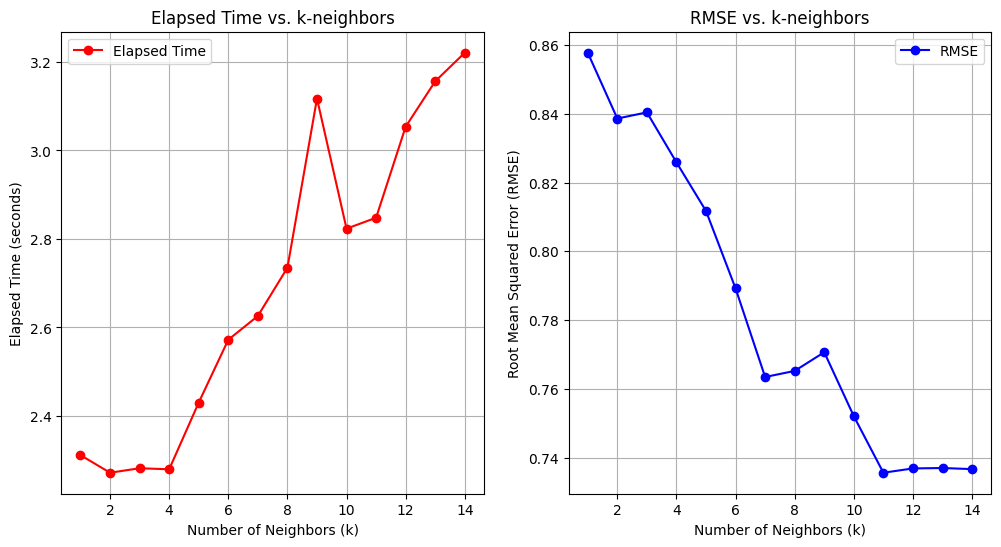

In [141]:
# Extract data for plotting
k_values = [item[0] for item in analytics]
rmse_values = [item[1] for item in analytics]
time_values = [item[2] for item in analytics]

# Create a figure with subplots
plt.figure(figsize=(12, 6))

# Plot elapsed time vs. k-neighbors
plt.subplot(1, 2, 1)
plt.plot(k_values, time_values, marker='o', linestyle='-', color='r', label='Elapsed Time')
plt.title('Elapsed Time vs. k-neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Elapsed Time (seconds)')
plt.grid(True)
plt.legend()

# Plot RMSE vs. k-neighbors
plt.subplot(1, 2, 2)
plt.plot(k_values, rmse_values, marker='o', linestyle='-', color='b', label='RMSE')
plt.title('RMSE vs. k-neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.grid(True)
plt.legend()
plt.savefig("./output/plots/knn.pdf")
plt.show()

In [ ]:
pipe = Pipeline(
    [
            ('scaling', StandardScaler()), 
            ("model", KNeighborsRegressor(n_neighbors=13, weights='distance',
                                                  algorithm='brute', n_jobs=-1))
    ])

pipe.fit(input_train, output_train)
print('trained')
y_hat = pipe.predict(input_validation)
y_hat_test = pipe.predict(input_test)
y_hat_submission = pipe.predict(input_submission)
save_predictions_to_csv(y_hat_test, "knn_test")
save_predictions_to_csv(y_hat_submission, "knn_submission")
rmse = root_mean_squared_error(output_validation, y_hat)
rmse_test = root_mean_squared_error(output_test, y_hat_test)

print("RMSE: ", rmse)
print("RMSE Test: ", rmse_test)
print(f'k: {13} with RMSE: {rmse}')


trained


## Task 4.2 Evaluation

In [ ]:
plot_y_yhat(output_validation.to_numpy(), pd.DataFrame(y_hat).to_numpy(), plot_title="knn_yhat")

# Task 5 [Optional]

#### 5.1 LightGBM

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb

pipe = Pipeline(
    [
        ('scaling', StandardScaler()), 
        ('model', MultiOutputRegressor(
            lgb.LGBMRegressor(num_leaves=100, learning_rate=0.01, n_estimators=500, num_iterations=1000)
        ))
    ]
)

pipe

In [ ]:

pipe.fit(input_train, output_train)

In [ ]:
y_hat = pipe.predict(input_validation)
y_hat_test = pipe.predict(input_test)
y_hat_submission = pipe.predict(input_submission)
save_predictions_to_csv(y_hat_test, "lgbm_test")
save_predictions_to_csv(y_hat_submission, "lgbm_submission")
rmse = root_mean_squared_error(output_validation, y_hat)
rmse_test = root_mean_squared_error(output_test, y_hat_test)

print("RMSE: ", rmse)
print("RMSE Test: ", rmse_test)
print(f'LightGBM with RMSE: {rmse}')

#### 5.2 Neural Networks

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error
from sklearn.neural_network import MLPRegressor

pipe = Pipeline(
    [
        ('scaling', StandardScaler()), 
        ('model', MLPRegressor(
            alpha=0.01,
            solver='adam',
            random_state=1, 
            max_iter=400,
            activation='relu',
            hidden_layer_sizes=(100, 100, 500, 500, 100, 100, 100,100, 100)
        ))
    ]
)

pipe

In [ ]:
pipe.fit(input_train, output_train)

In [ ]:
y_hat = pipe.predict(input_validation)
y_hat_test = pipe.predict(input_test)
y_hat_submission = pipe.predict(input_submission)
save_predictions_to_csv(y_hat_test, "nn_test")
save_predictions_to_csv(y_hat_submission, "nn_submission")
rmse = root_mean_squared_error(output_validation, y_hat)
rmse_test = root_mean_squared_error(output_test, y_hat_test)

print("RMSE: ", rmse)
print("RMSE Test: ", rmse_test)
print(f'NeuralNetworks with RMSE: {rmse}')

#### AutoML

In [ ]:
import autosklearn

model = autosklearn.regression.AutoSklearnRegressor(
    memory_limit=80048,
    time_left_for_this_task=60*30,
    per_run_time_limit=60*30/10,
    tmp_folder="./tmp/autosklearn_regression_example_tmp",
    n_jobs=-1,
    ensemble_size=0,
    metric=autosklearn.metrics.mean_squared_error
)
model.fit(input_train, output_train)

In [ ]:
model.leaderboard()

In [ ]:
y_hat = model.predict(input_validation)
y_hat_test = model.predict(input_test)
y_hat_submission = model.predict(input_submission)
save_predictions_to_csv(y_hat_test, "automl_test")
save_predictions_to_csv(y_hat_submission, "automl_submission")
rmse = root_mean_squared_error(output_validation, y_hat)
rmse_test = root_mean_squared_error(output_test, y_hat_test)
print("RMSE: ", rmse)
print("RMSE Test: ", rmse_test)
print(f'Automl with RMSE: {rmse}')